In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [4]:
# Load dataset
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [5]:
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [6]:
# Drop customerID
df.drop('customerID', axis=1, inplace=True)

In [7]:
# Convert TotalCharges to numeric and handle missing
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

/tmp/ipython-input-4109405308.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


In [8]:
# Encode binary categorical variables
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    if df[col].nunique() == 2:
        df[col] = le.fit_transform(df[col])

In [9]:
# One-hot encode the rest
df = pd.get_dummies(df)

In [10]:
# Split into X and y
X = df.drop('Churn', axis=1)
y = df['Churn']

In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [12]:
# Initialize models
lr_model = LogisticRegression(max_iter=1000)
rf_model = RandomForestClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

In [13]:
# Train models
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:20:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.56      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.80      0.80      0.80      1409

Logistic Regression ROC-AUC Score: 0.8424


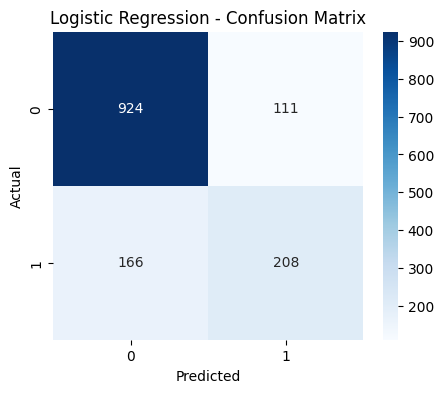

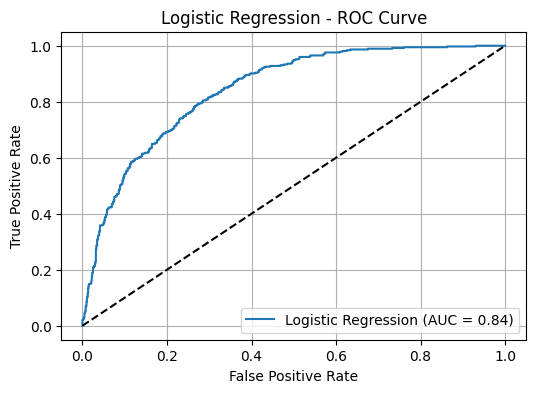


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1035
           1       0.61      0.51      0.55       374

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.71      1409
weighted avg       0.77      0.78      0.78      1409

Random Forest ROC-AUC Score: 0.8179


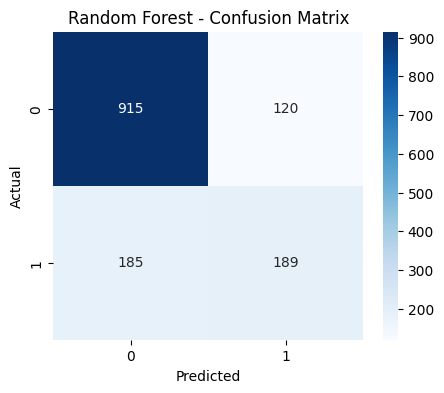

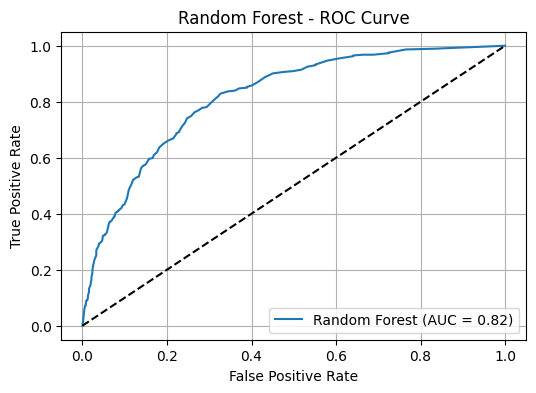


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1035
           1       0.61      0.54      0.57       374

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409

XGBoost ROC-AUC Score: 0.8254


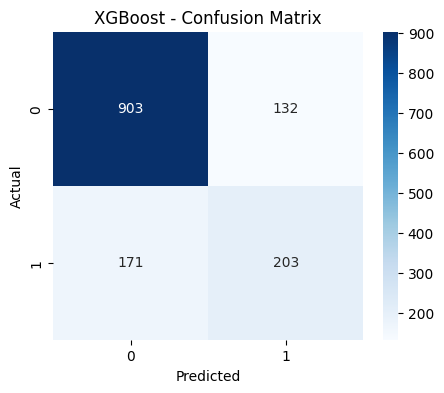

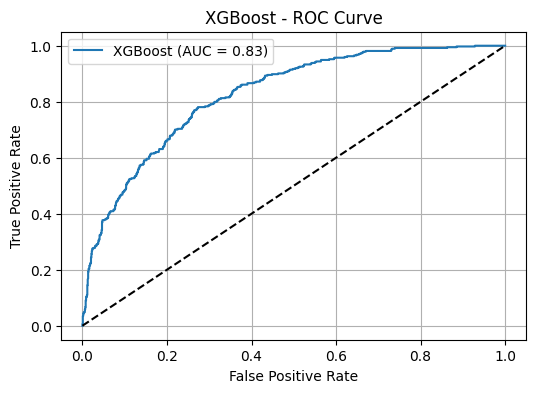

In [14]:
# Evaluation function
def evaluate_model(model, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"{name} ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} - ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

# Evaluate all models
evaluate_model(lr_model, "Logistic Regression")
evaluate_model(rf_model, "Random Forest")
evaluate_model(xgb_model, "XGBoost")

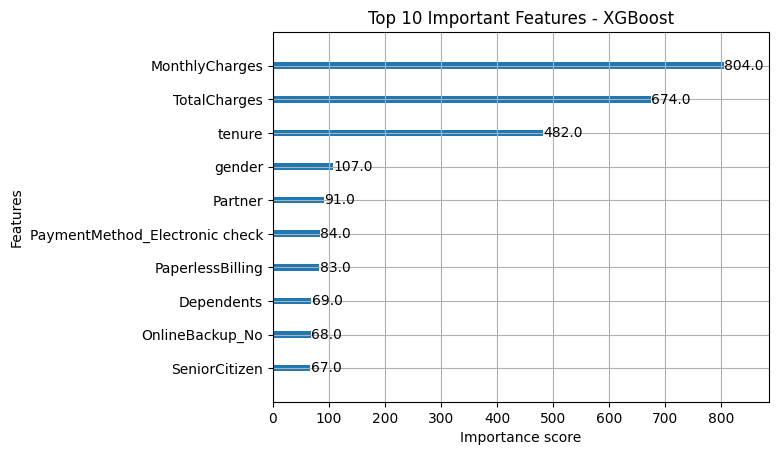

In [15]:
xgb.plot_importance(xgb_model, max_num_features=10)
plt.title("Top 10 Important Features - XGBoost")
plt.show()

In [16]:
predictions = pd.DataFrame({
    'Actual': y_test,
    'Predicted': xgb_model.predict(X_test),
    'Churn_Probability': xgb_model.predict_proba(X_test)[:, 1]
})
predictions.to_csv("churn_predictions.csv", index=False)

In [17]:
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=50,  # reduce from default 100
    max_depth=3,      # reduce tree depth
    random_state=42
)
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:21:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, ...)

In [18]:
# Churn predictions for dashboard
X_test_copy = X_test.copy()
X_test_copy['Churn_Probability'] = xgb_model.predict_proba(X_test)[:, 1]
X_test_copy['Actual'] = y_test.values
X_test_copy['Predicted'] = xgb_model.predict(X_test)
X_test_copy.to_csv("churn_data_dashboard.csv", index=False)
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
feature_importance.to_csv("feature_importance.csv", index=False)